# Visualization of the models

In [1]:
%pylab inline
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch import nn, optim
from VAE import *
from train import *
import numpy as np
from collections import *
import random
from sklearn.manifold import TSNE 
import pickle
import os
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_data():
    train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
    train_loader_scatter_plot = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, **{})
    train_loader_tsne = torch.utils.data.DataLoader(train_data, batch_size=10000, shuffle=False, **{})  
    return train_loader_scatter_plot, train_loader_tsne

def find_latent_coordinates(train_loader_scatter_plot, model):
   
    x_coordinates = defaultdict(lambda: [])
    y_coordinates = defaultdict(lambda: [])
   
    for batch_idx, (data, label) in enumerate(train_loader_scatter_plot):
        model = model.cpu()
        _, z, _ = model(data)
        index = label.data.cpu().numpy()[0]
       
        x_coordinates[index].append(z.data.cpu().numpy()[0][0])
        y_coordinates[index].append(z.data.cpu().numpy()[0][1])
       
        if batch_idx == 10000:
            break
           
    return x_coordinates, y_coordinates

def find_TSNE_coordinates(train_loader_scatter_plot, model):
   
    x_coordinates = defaultdict(lambda: [])
    y_coordinates = defaultdict(lambda: [])
   
    for batch_idx, (data, label) in enumerate(train_loader_scatter_plot):
        model = model.cpu()
        _, z, _ = model(data)
            
        labels = label.data.numpy()
        embedded = TSNE(n_components=2).fit_transform(z.data.cpu().numpy())
        if batch_idx == 0:
            break
           
    assert embedded.shape[0] == labels.shape[0]   
    for i in range(embedded.shape[0]):
        x_coordinates[labels[i]].append(embedded[i][0])
        y_coordinates[labels[i]].append(embedded[i][1])
       
    return x_coordinates, y_coordinates

def plot_loss(losses, labels):
    epoch_space = np.linspace(1,200,200)
    for i in range(len(losses)):
        plt.plot(epoch_space, losses[i], label=labels[i])
    plt.legend()
    plt.show()
   
def plot_grid(VAE):
    N = 15
    if VAE.method == 'Gaussian':
        M1, M2 = -10, 10
    elif VAE.method == 'Gumbel':
        M1, M2 = -100, -0.01
    else:
        M1, M2 = 0.001, 0.999
    rows = np.linspace(M1, M2, N)
    cols = np.linspace(M1, M2, N)
    for i in range (N):
        for j in range(N):
            z = torch.FloatTensor([[rows[i],cols[j]]])
            try:
                x = VAE.decode(z)
            except RuntimeError:
                x = VAE.decode(z.cuda()).cpu()
            plt.subplot(N,N,i*N+j+1)
            plt.axis('off')
            plt.imshow(x.data.numpy().reshape(28,28))
    plt.show()

def visualize_models(paths):
    train_loader_scatter_plot, train_loader_tsne = load_data()
    losses = []
    labels = []
    for path in paths:
        outputs = pickle.load( open( path, "rb" ) )
        print("Model type: {}, latent dimension: {} ".format(outputs[0].method, outputs[0].latent_dim))
        if outputs[0].method == 'logit':
            print("Variance = {}".format(path.split("_")[1][:-2]))
        if outputs[0].latent_dim == 2:
            plot_grid(outputs[0])
            x, y = find_latent_coordinates(train_loader_scatter_plot, outputs[0])
        else:
            x, y = find_TSNE_coordinates(train_loader_tsne, outputs[0])
        for label in x:
            plt.scatter(x[label], y[label], marker='.')
        plt.axis('off')
        plt.show()
        losses.append(outputs[4])
        label = outputs[0].method + ' ' + str(outputs[0].latent_dim)
        labels.append(label)
    plot_loss(losses, labels)

# Gaussian

In [23]:
files = glob.iglob('models/gauss/*.p')

Model type: Gaussian, latent dimension: 2 


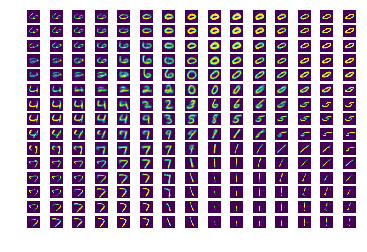

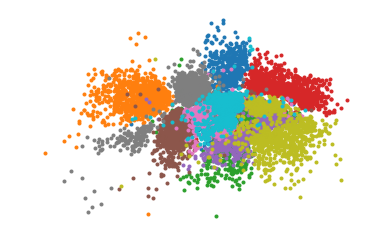

Model type: Gaussian, latent dimension: 8 


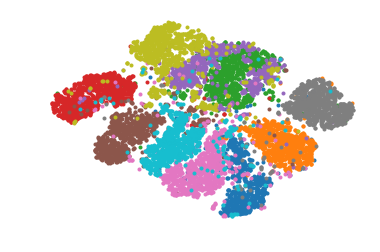

Model type: Gaussian, latent dimension: 40 


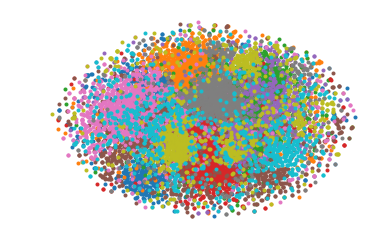

Model type: Gaussian, latent dimension: 4 


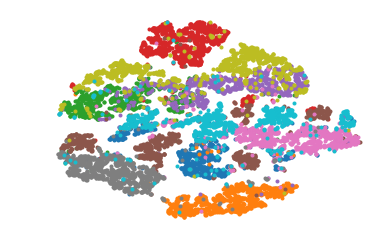

Model type: Gaussian, latent dimension: 20 


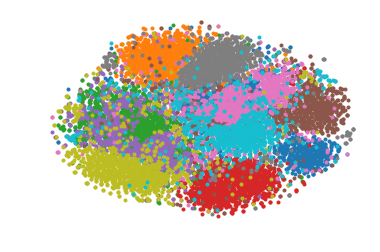

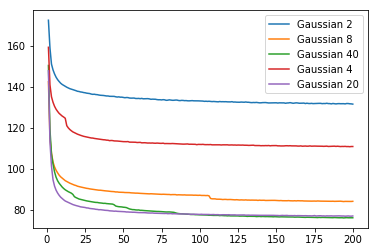

In [4]:
visualize_models(files)

In [24]:
files = [file for file in files]
train_loader_scatter_plot, train_loader_tsne = load_data()
for file in files:
    outputs = pickle.load( open( file, "rb" ) )
    print("Model type: {}, latent dimension: {} ".format(outputs[0].method, outputs[0].latent_dim))
    if outputs[0].method == 'logit':
        print("Variance = {}".format(file.split("_")[1][:-2]))
    print("    Last ELBO: {}".format(outputs[1][-1]))
    print("    Last Bernoulli Loss: {}".format(outputs[-1][-1]))

Model type: Gaussian, latent dimension: 2 
    Last ELBO: 138.58849421183268
    Last Bernoulli Loss: 131.49800267537435
Model type: Gaussian, latent dimension: 8 
    Last ELBO: 100.54219592412313
    Last Bernoulli Loss: 84.19606482187906
Model type: Gaussian, latent dimension: 40 
    Last ELBO: 96.21929983774821
    Last Bernoulli Loss: 76.18939569473267
Model type: Gaussian, latent dimension: 4 
    Last ELBO: 121.86820411046347
    Last Bernoulli Loss: 110.8667815208435
Model type: Gaussian, latent dimension: 20 
    Last ELBO: 96.52339597702026
    Last Bernoulli Loss: 77.06053146680196


# Gumbel

In [37]:
files = glob.iglob('models/gumbel/*.p')

Model type: Gumbel, latent dimension: 40 


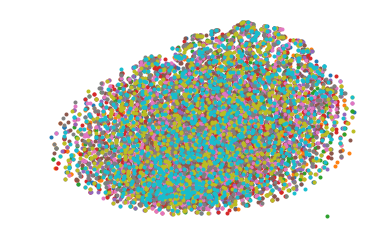

Model type: Gumbel, latent dimension: 4 


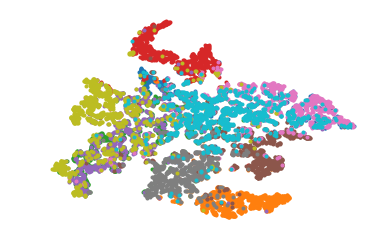

Model type: Gumbel, latent dimension: 8 


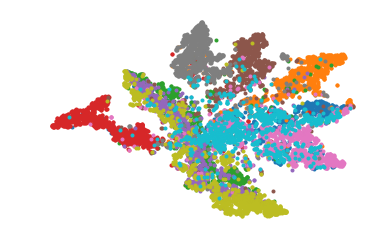

Model type: Gumbel, latent dimension: 20 


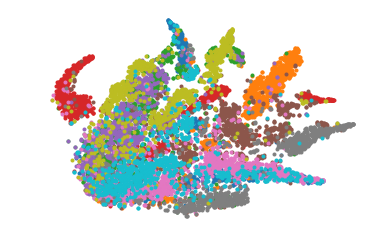

Model type: Gumbel, latent dimension: 2 


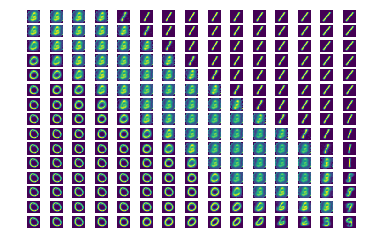

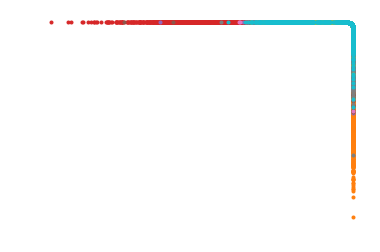

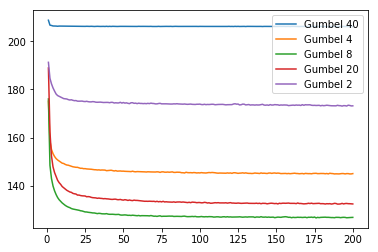

In [8]:
visualize_models(files)

In [38]:
files = [file for file in files]
train_loader_scatter_plot, train_loader_tsne = load_data()
for file in files:
    outputs = pickle.load( open( file, "rb" ) )
    print("Model type: {}, latent dimension: {} ".format(outputs[0].method, outputs[0].latent_dim))
    if outputs[0].method == 'logit':
        print("Variance = {}".format(file.split("_")[1][:-2]))
    print("    Last ELBO: {}".format(outputs[1][-1]))
    print("    Last Bernoulli Loss: {}".format(outputs[-1][-1]))

Model type: Gumbel, latent dimension: 40 
    Last ELBO: 227.96630992889405
    Last Bernoulli Loss: 206.06738986968995
Model type: Gumbel, latent dimension: 4 
    Last ELBO: 167.8655335108439
    Last Bernoulli Loss: 145.1551497332255
Model type: Gumbel, latent dimension: 8 
    Last ELBO: 158.6248477045695
    Last Bernoulli Loss: 127.02268101374308
Model type: Gumbel, latent dimension: 20 
    Last ELBO: 169.0490495554606
    Last Bernoulli Loss: 132.58889917373656
Model type: Gumbel, latent dimension: 2 
    Last ELBO: 185.8851033147176
    Last Bernoulli Loss: 173.22756935119628


# Logit 0.32

In [27]:
files = glob.iglob('models/logit/*_32.p')

Model type: logit, latent dimension: 2 
Variance = 32


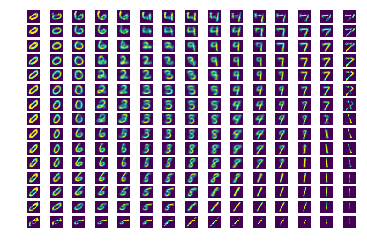

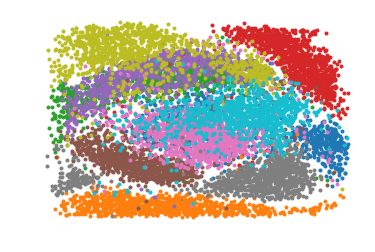

Model type: logit, latent dimension: 8 
Variance = 32


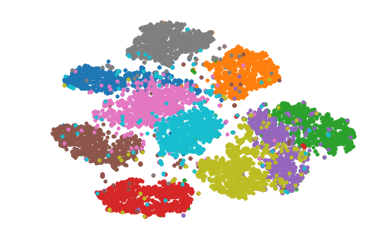

Model type: logit, latent dimension: 4 
Variance = 32


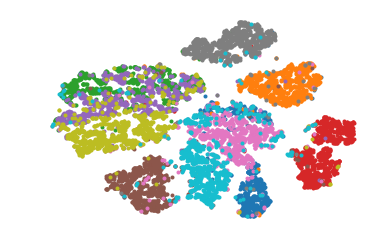

Model type: logit, latent dimension: 20 
Variance = 32


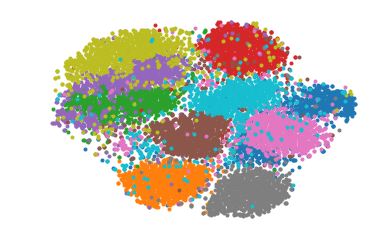

Model type: logit, latent dimension: 40 
Variance = 32


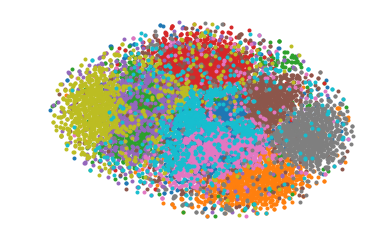

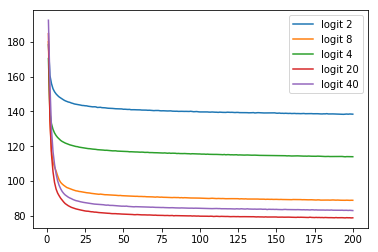

In [11]:
visualize_models(files)

In [28]:
files = [file for file in files]
train_loader_scatter_plot, train_loader_tsne = load_data()
for file in files:
    outputs = pickle.load( open( file, "rb" ) )
    print("Model type: {}, latent dimension: {} ".format(outputs[0].method, outputs[0].latent_dim))
    if outputs[0].method == 'logit':
        print("Variance = {}".format(file.split("_")[1][:-2]))
    print("    Last ELBO: {}".format(outputs[1][-1]))
    print("    Last Bernoulli Loss: {}".format(outputs[-1][-1]))

Model type: logit, latent dimension: 2 
Variance = 32
    Last ELBO: 145.42306518554688
    Last Bernoulli Loss: 138.4176483154297
Model type: logit, latent dimension: 8 
Variance = 32
    Last ELBO: 105.023128490448
    Last Bernoulli Loss: 89.00510484695434
Model type: logit, latent dimension: 4 
Variance = 32
    Last ELBO: 124.03926086425781
    Last Bernoulli Loss: 114.0118637084961
Model type: logit, latent dimension: 20 
Variance = 32
    Last ELBO: 99.9804613494873
    Last Bernoulli Loss: 78.95659585316976
Model type: logit, latent dimension: 40 
Variance = 32
    Last ELBO: 104.13200975418091
    Last Bernoulli Loss: 83.11519524892171


# Logit 0.56

In [29]:
files = glob.iglob('models/logit/*_56.p')

Model type: logit, latent dimension: 2 
Variance = 56


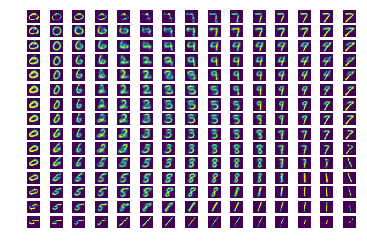

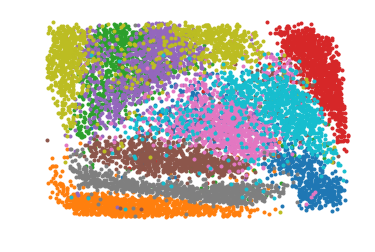

Model type: logit, latent dimension: 40 
Variance = 56


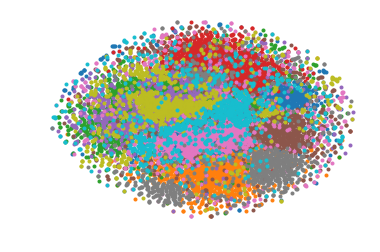

Model type: logit, latent dimension: 8 
Variance = 56


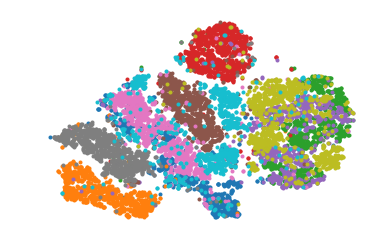

Model type: logit, latent dimension: 20 
Variance = 56


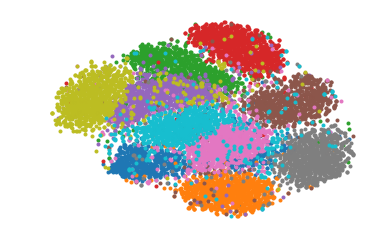

Model type: logit, latent dimension: 4 
Variance = 56


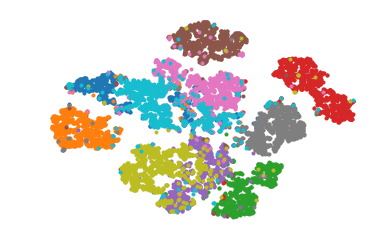

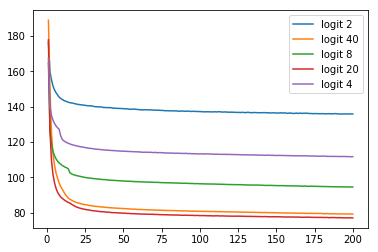

In [14]:
visualize_models(files)

In [30]:
files = [file for file in files]
train_loader_scatter_plot, train_loader_tsne = load_data()
for file in files:
    outputs = pickle.load( open( file, "rb" ) )
    print("Model type: {}, latent dimension: {} ".format(outputs[0].method, outputs[0].latent_dim))
    if outputs[0].method == 'logit':
        print("Variance = {}".format(file.split("_")[1][:-2]))
    print("    Last ELBO: {}".format(outputs[1][-1]))
    print("    Last Bernoulli Loss: {}".format(outputs[-1][-1]))

Model type: logit, latent dimension: 2 
Variance = 56
    Last ELBO: 142.67316679000854
    Last Bernoulli Loss: 135.88421005884805
Model type: logit, latent dimension: 40 
Variance = 56
    Last ELBO: 100.25264266967774
    Last Bernoulli Loss: 79.24138923009237
Model type: logit, latent dimension: 8 
Variance = 56
    Last ELBO: 109.42597539901733
    Last Bernoulli Loss: 94.50458868026733
Model type: logit, latent dimension: 20 
Variance = 56
    Last ELBO: 98.45185720443726
    Last Bernoulli Loss: 77.07870854059856
Model type: logit, latent dimension: 4 
Variance = 56
    Last ELBO: 121.73456642786662
    Last Bernoulli Loss: 111.76425698598226


# Logit 1.0

In [31]:
files = glob.iglob('models/logit/*_1.p')

Model type: logit, latent dimension: 20 
Variance = 1


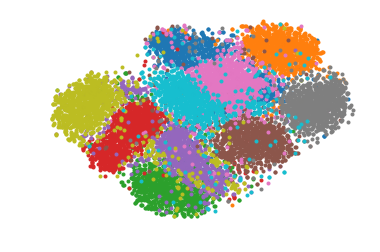

Model type: logit, latent dimension: 4 
Variance = 1


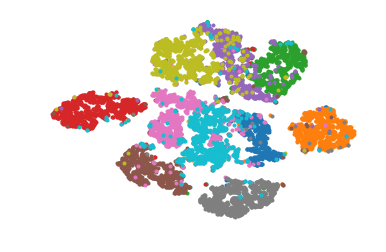

Model type: logit, latent dimension: 8 
Variance = 1


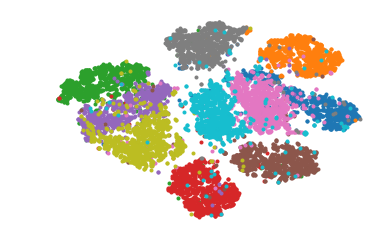

Model type: logit, latent dimension: 40 
Variance = 1


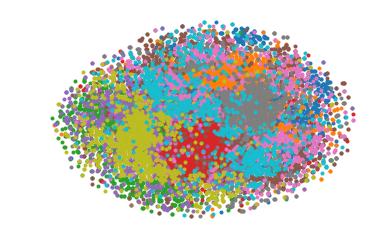

Model type: logit, latent dimension: 2 
Variance = 1


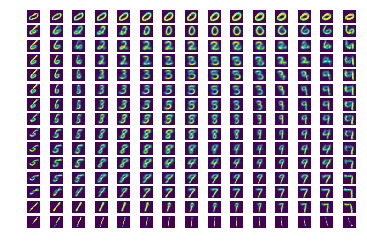

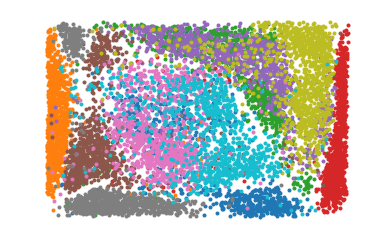

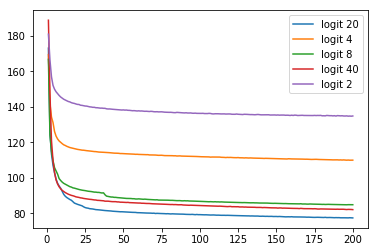

In [17]:
visualize_models(files)

In [32]:
files = [file for file in files]
train_loader_scatter_plot, train_loader_tsne = load_data()
for file in files:
    outputs = pickle.load( open( file, "rb" ) )
    print("Model type: {}, latent dimension: {} ".format(outputs[0].method, outputs[0].latent_dim))
    if outputs[0].method == 'logit':
        print("Variance = {}".format(file.split("_")[1][:-2]))
    print("    Last ELBO: {}".format(outputs[1][-1]))
    print("    Last Bernoulli Loss: {}".format(outputs[-1][-1]))

Model type: logit, latent dimension: 20 
Variance = 1
    Last ELBO: 97.61741974512736
    Last Bernoulli Loss: 77.47873441060383
Model type: logit, latent dimension: 4 
Variance = 1
    Last ELBO: 120.1031064414978
    Last Bernoulli Loss: 109.9611004447937
Model type: logit, latent dimension: 8 
Variance = 1
    Last ELBO: 101.61267997741699
    Last Bernoulli Loss: 84.90017075856527
Model type: logit, latent dimension: 40 
Variance = 1
    Last ELBO: 100.45458904902141
    Last Bernoulli Loss: 82.13783636728922
Model type: logit, latent dimension: 2 
Variance = 1
    Last ELBO: 141.3348390897115
    Last Bernoulli Loss: 134.80225828170776


# Logit 1.78

In [33]:
files = glob.iglob('models/logit/*_178.p')

Model type: logit, latent dimension: 2 
Variance = 178


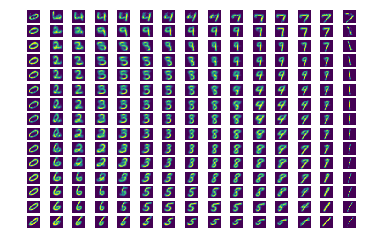

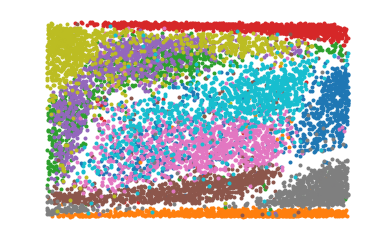

Model type: logit, latent dimension: 8 
Variance = 178


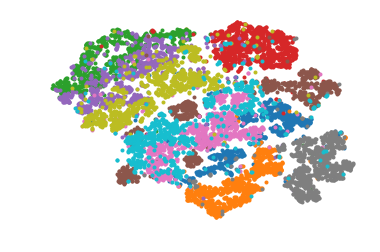

Model type: logit, latent dimension: 20 
Variance = 178


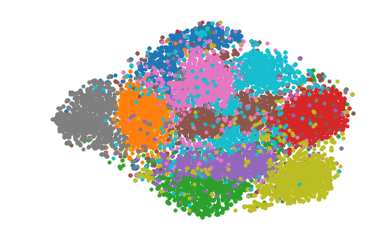

Model type: logit, latent dimension: 40 
Variance = 178


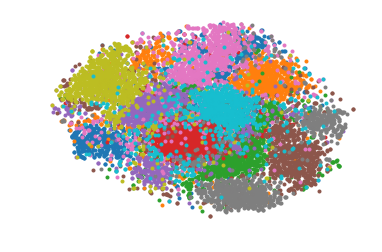

Model type: logit, latent dimension: 4 
Variance = 178


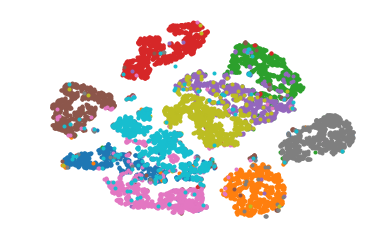

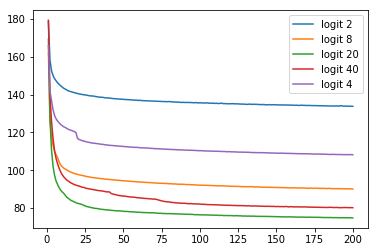

In [20]:
visualize_models(files)

In [34]:
files = [file for file in files]
train_loader_scatter_plot, train_loader_tsne = load_data()
for file in files:
    outputs = pickle.load( open( file, "rb" ) )
    print("Model type: {}, latent dimension: {} ".format(outputs[0].method, outputs[0].latent_dim))
    if outputs[0].method == 'logit':
        print("Variance = {}".format(file.split("_")[1][:-2]))
    print("    Last ELBO: {}".format(outputs[1][-1]))
    print("    Last Bernoulli Loss: {}".format(outputs[-1][-1]))

Model type: logit, latent dimension: 2 
Variance = 178
    Last ELBO: 140.2128432337443
    Last Bernoulli Loss: 133.84321930567424
Model type: logit, latent dimension: 8 
Variance = 178
    Last ELBO: 105.56507168451945
    Last Bernoulli Loss: 90.08676727930705
Model type: logit, latent dimension: 20 
Variance = 178
    Last ELBO: 96.96692744572957
    Last Bernoulli Loss: 74.78840782483418
Model type: logit, latent dimension: 40 
Variance = 178
    Last ELBO: 104.02170490264892
    Last Bernoulli Loss: 80.17938662846883
Model type: logit, latent dimension: 4 
Variance = 178
    Last ELBO: 118.63128582000732
    Last Bernoulli Loss: 108.20777622858684


# Plotting Bernoulli Loss for each laten dimension

In [48]:
def plot_loss_latent_dim(files):
    losses = []
    labels = []
    for file in files:
        outputs = pickle.load( open( file, "rb" ) )
        losses.append(outputs[4])
        label = outputs[0].method + ' ' + str(outputs[0].latent_dim)
        if 'logit' in file:
            label = label + ' ' + file.split("_")[1][:-2]
        labels.append(label)
    plot_loss(losses, labels)

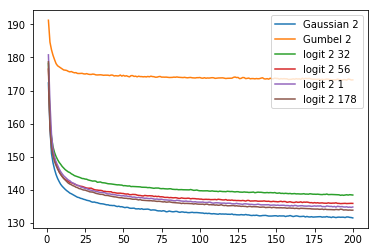

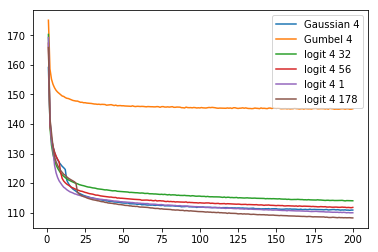

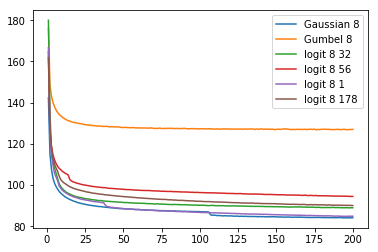

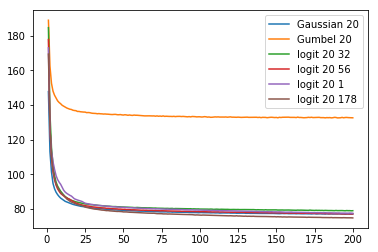

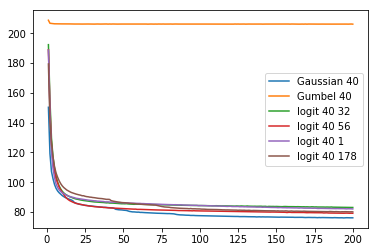

In [49]:
dimensions = [['models/gauss/gauss2.p', 'models/gumbel/gumbel2.p', 'models/logit/logit2_32.p', 
               'models/logit/logit2_56.p', 'models/logit/logit2_1.p', 'models/logit/logit2_178.p'],
              ['models/gauss/gauss4.p', 'models/gumbel/gumbel4.p', 'models/logit/logit4_32.p', 
               'models/logit/logit4_56.p', 'models/logit/logit4_1.p', 'models/logit/logit4_178.p'],
              ['models/gauss/gauss8.p', 'models/gumbel/gumbel8.p', 'models/logit/logit8_32.p', 
               'models/logit/logit8_56.p', 'models/logit/logit8_1.p', 'models/logit/logit8_178.p'],
              ['models/gauss/gauss20.p', 'models/gumbel/gumbel20.p', 'models/logit/logit20_32.p', 
               'models/logit/logit20_56.p', 'models/logit/logit20_1.p', 'models/logit/logit20_178.p'],
              ['models/gauss/gauss40.p', 'models/gumbel/gumbel40.p', 'models/logit/logit40_32.p', 
               'models/logit/logit40_56.p', 'models/logit/logit40_1.p', 'models/logit/logit40_178.p']
             ]
for dim in dimensions:
    plot_loss_latent_dim(dim)

# Plotting the histograms of the Z space

In [5]:
def plot_histogram(title_str, z):
    hist_values = [[] for i in range(len(z))]
    
    for i in range(z[0].size(0)):
        for j in range(len(z)):
            hist_values[i].append(float(z[j][i]))
        plt.hist(hist_values[i],  bins = 10, histtype=u'step')
        plt.title(title_str + ", z-dimension {}".format(i+1))
        plt.show()

### Logit 2 dim

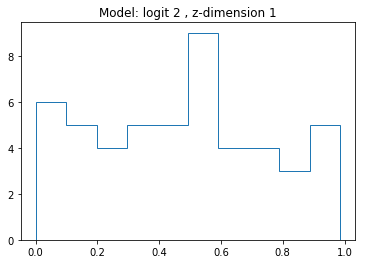

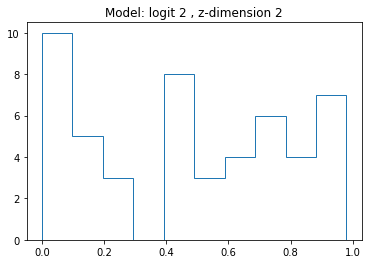

In [6]:
file = 'models/logit/logit2_178.p'
outputs = pickle.load(open(file, "rb"))
title = "Model: {} {} ".format(outputs[0].method, outputs[0].latent_dim)
plot_histogram(title, outputs[2])

### Gaussian 2 dim

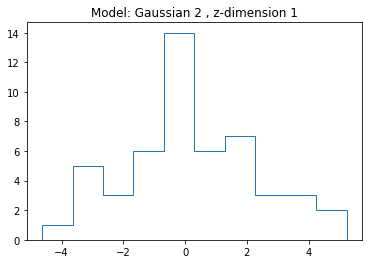

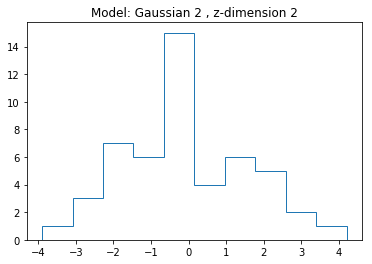

In [7]:
file = 'models/gauss/gauss2.p'
outputs = pickle.load(open(file, "rb"))
title = "Model: {} {} ".format(outputs[0].method, outputs[0].latent_dim)
plot_histogram(title, outputs[2])

### Gumbel 2 dim

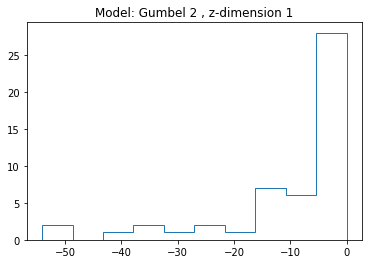

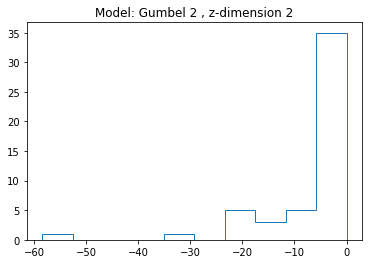

In [8]:
file = 'models/gumbel/gumbel2.p'
outputs = pickle.load(open(file, "rb"))
title = "Model: {} {} ".format(outputs[0].method, outputs[0].latent_dim)
plot_histogram(title, outputs[2])